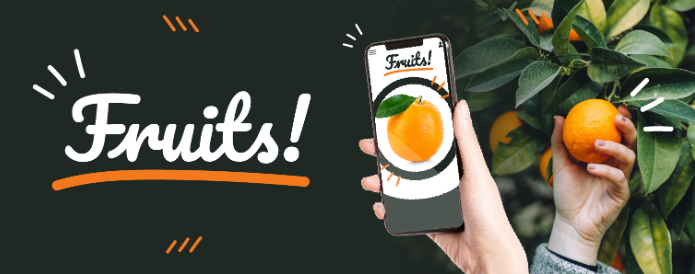

In [1]:
from functions import *
loopy = findColor("loopy.png")
loopy

'#f67a1c'

In [2]:
# add notebook summary
import jyquickhelper as jqh
from jyquickhelper import add_notebook_menu
add_notebook_menu(menu_id='OCDA_P9_local_deployment', raw=False, format='html',
                  header="FRUITS! PROJECT - NOTEBOOK 1 SUMMARY - Local deployment", first_level=1, last_level=5, keep_item=None)

# Preamble

**BUSINESS CASE :** The very young AgriTech start-up, called “Fruits!”,seeks to offer innovative solutions for fruit harvesting.
The company's desire is to preserve the biodiversity of fruits by allowing specific treatments for each species of fruit by developing intelligent picking robots.  The start-up initially wishes to make itself known by putting available to the general public a mobile application which would allow users to take a photo of a fruit and get information about that fruit. For the start-up, this application would raise awareness among the general public to fruit biodiversity and to set up a first version of the engine classification of fruit images. In addition, the development of the mobile application will make it possible to build
a first version of the necessary Big Data architecture.

**OBJECTIVES :**
- Develop an initial data processing chain that will include preprocessing and a dimension reduction step.
- Take into account that the volume of data will increase very quickly after delivery of this project, which involves deploying data processing in a Big Data environment and developing scripts in Pyspark to perform distributed computing.

**PROJECT STAGES :** The project will be carried out in two stages, in two different environments. We will first develop and execute our code locally, by working on a limited number of images to process. Once the technical choices have been validated, we will deploy our solution in a Big Data environment in distributed mode. This project will therefore be divided into 3 parts:
- List of general technical choices retained
- Deployment of the solution locally
- Deployment of the solution in the cloud

**TECH STACK :**
- *Distributed computing :* The project statement requires us to develop scripts in pyspark in order to take into account the very rapid increase in volume data after delivery of the project. In both environments (Local and Cloud) we will therefore use Spark
and we will exploit it through python scripts using PySpark. In the local version of our script we will simulate distributed computing in order to validate that our solution works. In the cloud version we will carry out operations on a machine cluster ;
- *Transfer learning :* The project brief also asks us to carry out a first processing chain data which will include preprocessing and a dimension reduction step. It is also specified that it is not necessary to train a model at the moment. We decide to go with a transfer learning solution. Simply, transfer learning consists to use the knowledge already acquired by a trained model (here MobileNetV2) to adapt it to our problem. We're going to provide the model with our images, and we're going to recover the penultimate layer of the model. Indeed the last model layer is a softmax layer which allows the classification of images which we do not need for this project. The penultimate layer corresponds to a vector reduced in size (1,1,1280). This will make it possible to produce a first version of the engine for classification of fruit images. MobileNetV2 was chosen for its speed of execution, particularly suitable for processing a large volume of data as well as the low dimensionality of the vector characteristic output (1,1,1280)

# 1. - Local deployment

## 1.1 - Environment

## 1.2 - Packages installations

For simplicity reasons, we develop in a Linux Ubuntu environment (running on Windows from a virtual machine).

In [3]:
# !pip install --user pillow

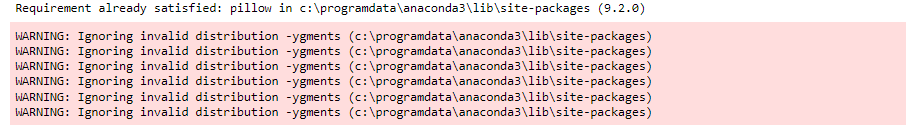

In [4]:
# !pip install --user tensorflow

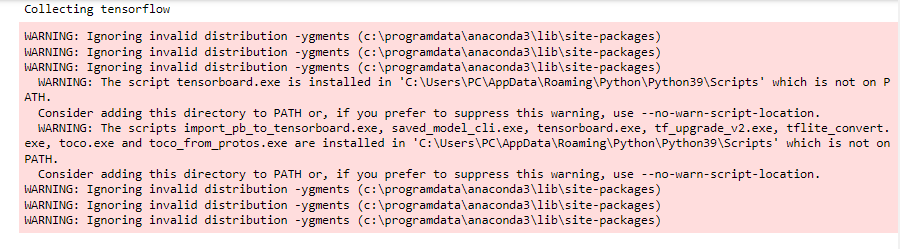

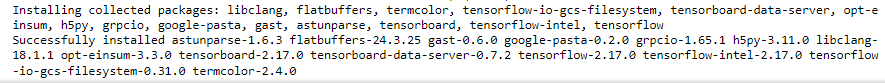

In [5]:
# !pip install --user pyspark

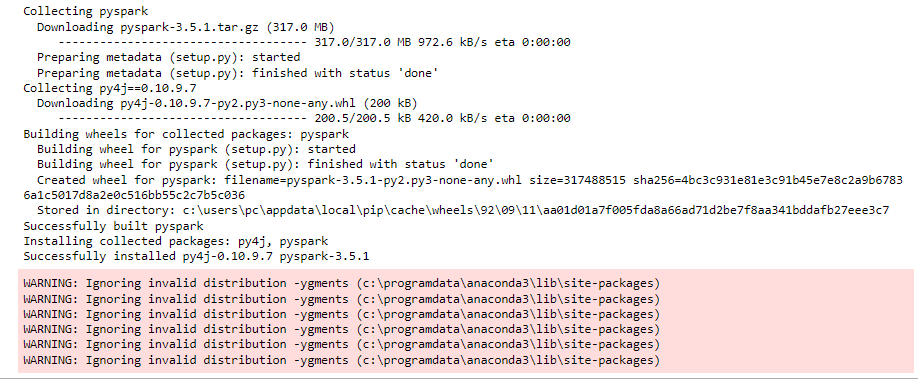

In [6]:
# !pip install --user pyarrow

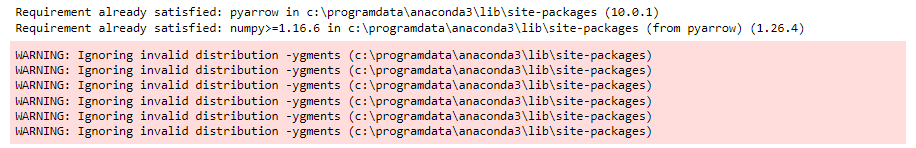

- After deleting ~ygments temp directory in c:\programdata\anaconda3\lib\site-packages:
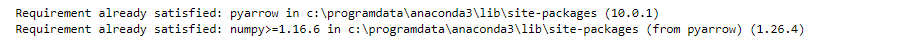



## 1.3 - Import librairies

In [7]:
# !pip install pillow

In [8]:
import pandas as pd
from PIL import Image
import numpy as np
import io
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable


import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql import SparkSession

# set dataframe display options
pd.set_option('max_colwidth', None)
pd.set_option('display.max_columns', None)

# silence warnings after checking
import warnings
pd.set_option('future.no_silent_downcasting', False)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


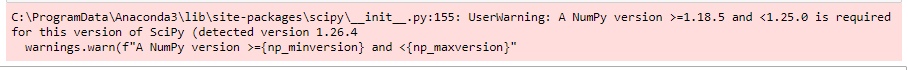

In [9]:
# solve the NumPy version warning
# !pip install --user --upgrade scipy

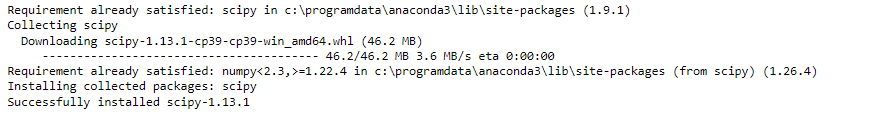

## 1.4 - Define PATH for image downloading and results uploading

In this local version we assume that the data are stored in the same directory as the notebook. We only use a sample of 64 images to process in this first local version. The sample images to load are stored in the Test1 folder. We will record the result of our treatment in the "Results_Local" folder.

In [10]:
PATH = os.getcwd()
PATH_Data = PATH+'/data/Test1'
PATH_Results = PATH+'/data/Results_Local'
PATH_PCA = PATH+'/data/PCA_Results'
print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Results: '+\
      PATH_PCA+'\nPATH_PCA: '+PATH_PCA)

PATH:        C:\Users\PC\DA Projets Python\OC-DS\PROJET 9
PATH_Data:   C:\Users\PC\DA Projets Python\OC-DS\PROJET 9/data/Test1
PATH_Results: C:\Users\PC\DA Projets Python\OC-DS\PROJET 9/data/PCA_Results
PATH_PCA: C:\Users\PC\DA Projets Python\OC-DS\PROJET 9/data/PCA_Results


## 1.5 - Initialize Spark Session

The Spark application is controlled using a driver process called SparkSession. A SparkSession instance is how Spark executes user-defined functions throughout the cluster. A SparkSession always corresponds to a Spark application. Here we create a spark session by specifying in order:
- a name for the application, which will be displayed in the Spark "P9" web UI that the application must run locally;
- we do not define the number of cores to use (like .master('local[4]) for 4 cores to use), so we will use all available cores in our processor;
- an additional configuration option allowing the use of the “parquet” format, which we will use to save and load the result of our work; and
- use an existing spark session or if none exists, create a new one.

In [11]:
# !pip install --user findspark

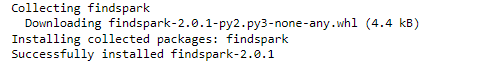

In [12]:
# this solves error "Python worker failed to connect back" at In[27] below
import findspark
findspark.init()

In [13]:
spark = (SparkSession.builder.appName('P9').master('local').config("spark.sql.parquet.writeLegacyFormat", 'true').getOrCreate())

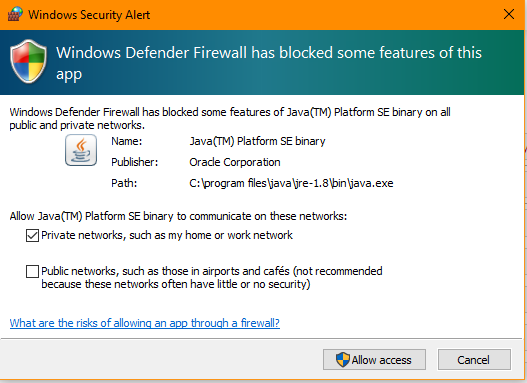

We also create the "sc" variable which is a SparkContext from the spark variable:

In [14]:
sc = spark.sparkContext

Display current Spark session information:

In [15]:
spark

## 1.6 - Data processing

In the rest of our workflow, we will successively:
- Prepare our data;
- Import images into a pandas UDF dataframe;
- Associate their label with the images;
- Preprocess by resizing our images to that they are compatible with our model;
- Prepare our model;
- Import MobileNetV2 model;
- Create a new model without the last layer of MobileNetV2;
- Set image loading process and application of their featurization through the use of pandas UDF;
- Execute feature extraction actions;
- Record the results of our actions; and
- Test correct operation by loading the recorded data.

pyspark.sql.functions.pandas_udf(f=None, returnType=None, functionType=None)
Creates a pandas user defined function (a.k.a. vectorized user defined function).

Pandas UDFs are user defined functions that are executed by Spark using Arrow to transfer data and Pandas to work with the data, which allows vectorized operations. A Pandas UDF is defined using the pandas_udf as a decorator or to wrap the function, and no additional configuration is required. A Pandas UDF behaves as a regular PySpark function API in general.

New in version 2.3.0.

Parameters
ffunction, optional
user-defined function. A python function if used as a standalone function

returnTypepyspark.sql.types.DataType or str, optional
the return type of the user-defined function. The value can be either a pyspark.sql.types.DataType object or a DDL-formatted type string.

functionTypeint, optional
an enum value in pyspark.sql.functions.PandasUDFType. Default: SCALAR. This parameter exists for compatibility. Using Python type hints is encouraged.
Source : https://spark.apache.org/docs/3.1.2/api/python/reference/api/pyspark.sql.functions.pandas_udf.html

### 1.6.1 - Load data

- Images are loaded in binary format, which offers, more flexibility in how to preprocess images;
- Before loading the images we specify that we want to load only files with jpg extension;
- We also indicate to load all possible objects contained in the subfolders of the communicated folder.

In [16]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

- full text of error : "Py4JJavaError: An error occurred while calling o34.load.
: java.lang.UnsatisfiedLinkError: org.apache.hadoop.io.nativeio.NativeIO$Windows.access0(Ljava/lang/String;I)Z"
- error solved with : https://sparkbyexamples.com/spark/spark-hadoop-exception-in-thread-main-java-lang-unsatisfiedlinkerror-org-apache-hadoop-io-nativeio-nativeiowindows-access0ljava-lang-stringiz/
- Hadoop dll and winutils available here (this notebook uses version 3.0.0) : https://github.com/steveloughran/winutils/tree/master/hadoop-3.0.0)

Displaying the first 5 images containing:
- the image path;
- the date and time of its last modification;
- its length;
- its content encoded in hexadecimal value;
- only keep the path of the image is kept and a column containing the labels of each image is added.

In [17]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+------------------------------------------------------------------------------+-----+
|path                                                                          |label|
+------------------------------------------------------------------------------+-----+
|file:/C:/Users/PC/DA Projets Python/OC-DS/PROJET 9/data/Test1/lime/113_100.jpg|lime |
|file:/C:/Users/PC/DA Projets Python/OC-DS/PROJET 9/data/Test1/lime/114_100.jpg|lime |
|file:/C:/Users/PC/DA Projets Python/OC-DS/PROJET 9/data/Test1/lime/121_100.jpg|lime |
|file:/C:/Users/PC/DA Projets Python/OC-DS/PROJET 9/data/Test1/lime/120_100.jpg|lime |
|file:/C:/Users/PC/DA Projets Python/OC-DS/PROJET 9/data/Test1/lime/118_100.jpg|lime |
+------------------------------------------------------------------------------+-----+
only sh

### 1.6.2 - Instanciate model

The transfer learning technique will be used to extract features from images ; the MobileNetV2 model was used for its speed of execution compared to other models like VGG16 for example. See https://towardsdatascience.com/review-mobilenetv2-light-weight-model-image-classification-8febb490e61c

Transfer learning is a popular technique used with MobileNetV2 to leverage pre-trained models on large-scale datasets. By initializing the model with pre-trained weights, the training process can be accelerated, and the model can benefit from the knowledge learned from the source dataset. Source : https://www.analyticsvidhya.com/blog/2023/12/what-is-mobilenetv2/

The model has a final layer which is used to classify the images according to 1000 categories and which is not required for this project. The idea in this project is to recover only the feature vector of dimensions (1,1,1280) which will be used, later, through a motor classification to recognize the different fruits of the dataset.

Like similar models, MobileNetV2, when used by including all of its layers, necessarily expects images of dimension (224,224,3). Our images are all of dimension (100,100,3), we'll just have to resize them before handing them to the model.

In order:
- We load the MobileNetV2 model with the precalculated weights from imagenet and specifying the format of our input images
- We create a new model with:
-*input:* the input of the MobileNetV2 model
-*output:* the penultimate layer of the MobileNetV2 model

In [18]:
model = MobileNetV2(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

In [19]:
new_model = Model(inputs=model.input, outputs=model.layers[-2].output)

Showing the summary of our new model where we see that we indeed recover at the output a vector of dimension (1, 1, 1280):

In [20]:
new_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [21]:
# .get_weights() Return the values of layer.weights as a list of NumPy arrays
# see https://www.tensorflow.org/api_docs/python/tf/keras/Layer#get_weights
new_model.get_weights()

[array([[[[-1.71659231e-01, -3.33731920e-01,  5.30122258e-02,
           -5.93232973e-21,  2.08742931e-01, -1.20433941e-01,
            1.75700430e-02, -3.10708203e-22, -9.62498877e-03,
            1.90229788e-01, -3.67278278e-01,  3.95997976e-22,
           -2.36236629e-22,  3.36706383e-22,  8.83555040e-02,
           -7.75416642e-02,  3.95842289e-05, -3.63377742e-02,
            5.99925742e-02,  5.53736472e-21, -4.68022423e-04,
           -1.23387486e-01, -1.34351701e-01,  8.75968020e-03,
           -2.47503355e-01,  1.58492010e-02, -2.43145856e-04,
           -1.09811597e-01,  5.55126644e-22, -2.03368161e-03,
            2.83311605e-01,  7.66634047e-02],
          [-3.18941772e-01, -6.09864295e-01, -1.70770675e-01,
           -6.76705635e-21, -5.82342505e-01, -2.56068230e-01,
           -4.18974347e-02,  1.32427304e-22,  2.00757684e-04,
            3.29488933e-01, -4.01886106e-01,  3.63034420e-22,
            1.64733595e-22,  1.97648923e-22,  9.94425565e-02,
           -1.17755957e-

In [22]:
len(new_model.get_weights())

260

All workers must be able to access the model and its weights.
A good practice is to load the model on the driver then broadcast
then the weights for the different workers.

In PySpark, working with small DataFrames that are used repeatedly across multiple stages in a distributed processing pipeline can cause performance issues. To optimize the performance of these operations, PySpark provides a mechanism called broadcasting.
When a DataFrame is broadcasted, it is sent to all worker nodes and cached, ensuring that each node has a full copy of the data. This eliminates the need to shuffle and exchange data between nodes during operations, such as joins, significantly reducing the communication overhead and improving performance. Broadcasting the small DataFrame can significantly improve performance by reducing the amount of data that needs to be exchanged between worker nodes. In PySpark, you can broadcast a DataFrame using the broadcast() function from the pyspark.sql.functions module. To use the broadcast() function, simply pass the DataFrame you want to broadcast as an argument: 
from pyspark.sql.functions import broadcast         
broadcast_dataframe = broadcast(dataframe) 
Source : https://www.sparkcodehub.com/broadcasting-dataframes-in-pyspark

In [23]:
# layer_names = [l.name for l in model.layers]
# print(layer_names)

In [24]:
# len(layer_names)

In [25]:
# new_layer_names = [l.name for l in new_model.layers]
# print(new_layer_names)

In [26]:
#len(new_layer_names) # equals 156 minus the predictions layer which we have removed

In [27]:
from pyspark.sql.functions import broadcast
broadcast_weights = sc.broadcast(new_model.get_weights())

In [28]:
# call help on object
# ? sc.broadcast

Let's put this into a function:

In [29]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(broadcast_weights.value)
    return new_model

### 1.6.3 - Definition of the image loading process and application of their featurization through the use of pandas UDF

This notebook defines the logic in stages, up to Pandas UDF.

<u>The stacking of calls is as follows</u>:

- Pandas UDF
 - featurize a series of pd.Series images
 - preprocess an image

In [30]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction. When you load an image with imread(), the pixel values are in the 0 - 255
    range. However, MobileNetV2 expects pixel values to be in the -1 to 1 range. You could perform this transformation yourself,
    but Keras also provides preprocessing functions - use from keras.applications.mobilenet_v2 import preprocess_input
    source : https://pythontutorials.eu/deep-learning/image-classification/
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

In [31]:
def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    
    # make sure verbose is set to FALSE in model.predict otherwise
    # features_df.write.option("encoding", "utf-8").mode("overwrite").parquet(PATH_Results)
    # will raise a WIN1252 codec writing error when writing the parquet file at OUT[28] below
    preds = model.predict(input, verbose=0)  
       
    
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

In [32]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

### 1.6.4 - Executing feature extraction actions

Pandas UDF, on large recordings (for example, very large images), may encounter Out Of Memory (OOM) errors.
If you encounter any such errors in the cell below, try reducing Arrow batch size via 'maxRecordsPerBatch' (currently commented out)

In [33]:
# spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

We can now run featurization across our entire Spark DataFrame. NB: This can take a long time, depending on the volume of data to be processed.
Our Test dataset contains 22819 images. However, in local mode execution, we will process a reduced set of 64 images.

In [34]:
features_df = images.repartition(20).select(col("path"), col("label"), featurize_udf("content").alias("features"))

Reminder of the PATH where the files in "parquet" format will be registered containing our results, namely, a DataFrame containing 3 columns:
- Image path
- Image label
- Image feature vector

In [35]:
print(PATH_Results)

C:\Users\PC\DA Projets Python\OC-DS\PROJET 9/data/Results_Local


Saving processed data in “parquet” format:

- error "Python worker failed to connect back"
- solved with import findspark & findspark.init() - see https://stackoverflow.com/questions/53252181/python-worker-failed-to-connect-back

In [36]:
# %%timeit
# make sure verbose is set to FALSE in model.predict at IN[24] above otherwise the following error will be raised
# caused by org.apache.spark.sparkexception task failed while writing rows Anaconda3\lib\encodings\cp1252.py 'charmap' codec
# can't encode characters in position 19-38: character maps to <undefined>
features_df.write.option("encoding", "utf-8").mode("overwrite").parquet(PATH_Results)

## 1.7 - Loading recorded data and validating results

- Load data in a pandas dataframe:

In [37]:
df = pd.read_parquet(PATH_Results, engine='pyarrow')

- Display first 5 lines of dataframe:

In [38]:
df.head()

,path,label,features
0,file:/C:/Users/PC/DA Projets Python/OC-DS/PROJET 9/data/Test1/green_tomato/116_100.jpg,green_tomato,"[0.24269575, 0.38742015, 0.0, 0.0, 0.5465124, 0.031861372, 1.5262854, 0.0, 0.0, 0.0, 0.0, 0.063392386, 0.0, 0.061168104, 0.84450525, 0.18676493, 0.0, 0.17490211, 0.6683728, 0.9625305, 0.0, 0.13402371, 0.009945539, 0.02604831, 0.08758599, 0.0, 2.2825851, 0.48607308, 0.0, 1.7642393, 0.0, 1.521647, 0.0, 0.9179485, 0.0, 0.6622262, 0.72875214, 0.87483454, 0.004898782, 0.0, 0.017056456, 0.0, 1.1599686, 0.45510602, 0.0, 0.0, 0.032705337, 0.87036586, 0.93008494, 0.009621951, 0.384286, 0.13314553, 0.0, 0.0, 0.0, 0.39128697, 0.0, 0.2944446, 0.0, 0.7157571, 0.020341562, 1.2723155, 0.021819308, 0.0, 0.044319786, 0.0, 0.92756546, 0.10913013, 0.0, 0.34378612, 0.17092092, 0.0, 0.042070225, 0.02943036, 0.9114003, 0.09352967, 0.04990449, 0.0, 0.0, 0.0010335787, 0.0, 0.12238621, 0.0, 0.7244351, 0.3526296, 0.00060997205, 0.0, 0.13659443, 0.5075058, 0.2596267, 2.6994042, 0.053549834, 0.11541078, 0.23032695, 0.7263081, 0.0, 0.5029597, 0.0034279434, 0.0, 0.0, ...]"
1,file:/C:/Users/PC/DA Projets Python/OC-DS/PROJET 9/data/Test1/mango/11_100.jpg,mango,"[1.0582621, 0.30180922, 0.084705025, 0.0, 0.013671418, 1.3156215, 0.17807081, 0.026633905, 0.0, 0.037512477, 0.06641313, 0.056941733, 0.0, 0.0, 0.0, 0.0, 0.0, 0.019461028, 0.0695605, 0.1942373, 0.0, 0.526913, 0.026522335, 0.0, 0.0, 0.0, 1.1773294, 0.0402101, 0.0, 2.3214617, 0.005892053, 0.0791638, 0.0, 0.0043198233, 0.0, 0.9240314, 0.9602229, 0.036816675, 0.013248677, 0.0, 0.0015560462, 0.0, 0.0647761, 0.0099758515, 0.0, 0.0, 0.0, 0.1086606, 0.12635776, 0.0, 0.0, 0.21805055, 0.0, 0.0, 0.0, 0.30419603, 0.094787896, 1.0064458, 0.0, 0.001246355, 0.0, 1.3685383, 0.0, 0.0, 0.026167275, 0.085329086, 0.0, 0.0, 0.27836773, 0.09538256, 0.0, 0.15602882, 0.13769583, 0.21085839, 1.1005751, 0.7681672, 0.77883786, 0.0, 0.0, 0.09329595, 0.43825415, 0.020011395, 0.0003949574, 0.09866037, 0.0, 0.0, 0.0, 0.0, 0.016717229, 0.04814081, 1.0505139, 0.01229873, 0.0, 0.0, 0.69915867, 0.0, 0.012539445, 0.0, 0.1297621, 0.14305355, ...]"
2,file:/C:/Users/PC/DA Projets Python/OC-DS/PROJET 9/data/Test1/salak/11_100.jpg,salak,"[1.9909235, 0.17054252, 0.0026094087, 0.01673712, 0.0052764853, 0.0021161644, 0.82969826, 0.68632066, 0.010797238, 0.7662406, 0.0, 0.32889074, 0.02858557, 2.1385324, 0.027073374, 0.121545516, 0.0, 0.57688415, 0.27430856, 0.0, 0.09802091, 0.44770727, 0.059801765, 0.5626948, 0.25270864, 1.0025163, 0.28550875, 0.14598407, 0.07524042, 0.94807976, 0.0, 0.0, 0.6003041, 0.22935712, 0.014350804, 0.39680964, 2.1452608, 0.7964905, 1.8014612, 0.0, 0.043025583, 0.0005410739, 0.026078692, 0.082002915, 0.105440065, 0.029687677, 0.667254, 0.0, 0.026399154, 0.99809843, 0.0, 0.25571033, 1.5779507, 0.010931833, 0.43308368, 1.8286393, 0.0, 0.0043866974, 0.0, 0.0, 0.0, 0.5679618, 0.0, 0.0, 0.008350596, 2.7587006, 0.53945166, 0.0, 0.288717, 0.6642154, 0.0, 0.0, 0.0, 1.1152841, 0.047440693, 0.043829024, 1.7290101, 0.1027362, 0.0, 0.0, 0.0, 0.0, 0.10489216, 0.0, 0.06905169, 0.18146433, 0.0, 0.0, 1.4366003, 0.08213669, 1.0452851, 1.0322666, 0.052568737, 0.02987198, 1.7823573, 0.0, 0.9600757, 0.0, 0.007534358, 0.0, ...]"
3,file:/C:/Users/PC/DA Projets Python/OC-DS/PROJET 9/data/Test1/lime/121_100.jpg,lime,"[0.0, 0.0, 0.3482751, 0.0, 0.0, 0.0030790737, 0.025067212, 0.0, 0.050931316, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.23969099, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00083583716, 0.0, 0.0, 0.09189559, 0.0, 0.08908487, 0.0, 0.14870681, 1.1068392, 0.0, 0.0, 0.039819717, 0.0, 0.19370167, 0.1997797, 0.0, 1.6959426, 0.0, 0.0, 0.0, 0.09238685, 0.0, 0.0, 0.0, 0.21804637, 0.20571288, 0.0, 0.0, 0.0, 1.3401847, 0.0, 0.0, 0.0, 0.3355232, 0.0, 0.0, 0.0, 0.0, 0.007521425, 0.27461046, 0.0, 0.0, 0.009101537, 0.04834547, 0.118823536, 0.0, 0.0, 0.14007023, 0.0, 0.0, 0.18212637, 0.0, 0.2982405, 0.07120351, 0.0030615379, 0.0, 0.0, 0.0, 0.06518888, 0.12410974, 0.0, 0.0, 0.0, 0.21255915, 0.0, 0.0, 0.0, 0.9491386, 0.17127487, 0.0, 0.0, 0.0, 0.0,

- Validate that the image characteristics vector is indeed of dimension 1280:

In [39]:
df.loc[0,'features'].shape

(1280,)

# 1.8 - Dimensionality reduction : PCA using PySpark

As the PCA aims to reduce dimensions of images composed of pixels for which the color variations are all between 0 and 255 for each (R, G, B) tuple, normalisation of underlying data is normally not required for image compression. 

In [40]:
# import packages and functions required
from pyspark.ml.feature import PCA
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

When working with Big Data in Spark is that the machine learning algorithms require that the data is inputted as a vector. Source : https://towardsdatascience.com/ranking-diamonds-with-pca-in-pyspark-a59cab7f4f1a

In [41]:
# check data type of resulting dataframe vector column
df['features'].values.dtype

dtype('O')

In [42]:
# transform df['features'] vectors column into dataframe
# vstack rebuilds arrays divided by vsplit - see numpy doc at https://numpy.org/doc/stable/reference/generated/numpy.vstack.html
df2 = pd.DataFrame(np.vstack(df['features']))
df2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021

In [43]:
# careful - it is the Spark session (called 'spark' in this notebook) that has a createDataFrame attribute,
# not the Sark Context sc - see https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.SparkSession.createDataFrame.html
# and https://stackoverflow.com/questions/40651003/attributeerror-sparkcontext-object-has-no-attribute-createdataframe-using-s
# so this test_sdf = sc.createDataFrame(df2) triggers error
test_sdf = spark.createDataFrame(df2) # but this works just fine

In [44]:
# convert pandas df to Spark df
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
spark_df2 = sqlContext.createDataFrame(df2)

In [45]:
cols = df2.columns.astype(str).tolist()

# instanciate vector assembler 
assembler = VectorAssembler(inputCols=cols, outputCol="features")

prepared_df = assembler.transform(spark_df2)

In [46]:
# run PCA with all the possible components
pca = PCA(k= len(cols), inputCol="features")
pca.setOutputCol("pca_features")

# Fit
pca_model = pca.fit(prepared_df)

PCA explainedVariance returns a vector of proportions of variance explained by each principal component. See doc at https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.PCAModel.html

In [47]:
# pca_model.explainedVariance

In [48]:
sum(pca_model.explainedVariance)

1.0

In [72]:
# principal components Matrix. Each column is one principal component. See
# https://github.com/haipinglu/ScalableML/blob/master/Lab%207%20-%20Scalable%20PCA%20for%20dimensionality%20reduction%20and%20Spark%20data%20types.md
print(pca_model.pc)
print(pca_model.pc.toArray().shape)

DenseMatrix([[-8.96968191e-02,  1.92836759e-02,  3.76618494e-04, ...,
               3.20672568e-03, -3.75201568e-03, -8.47794621e-05],
             [ 4.08319568e-03, -1.02424259e-02,  2.26376581e-02, ...,
              -2.49080167e-02, -5.83166049e-03, -2.06233094e-03],
             [ 7.67762918e-03, -9.18093100e-03, -1.42068286e-02, ...,
              -5.65283118e-03,  2.44592405e-03, -6.72124964e-03],
             ...,
             [ 1.54509918e-02,  2.31126599e-02, -5.53829343e-03, ...,
               1.14434987e-02,  9.93849028e-03, -3.92187107e-03],
             [ 2.39581898e-04, -2.01122235e-03,  3.99378579e-03, ...,
               7.32323822e-04, -8.84611128e-03, -4.33922649e-04],
             [-2.63772625e-02,  4.80638202e-03, -5.86702443e-03, ...,
               8.35465510e-03,  4.84759351e-03,  1.95064824e-02]])
(1280, 1280)


In [50]:
# explained variance of the PCs
df_var = pd.DataFrame(pca_model.explainedVariance, columns=['explained_var'])
df_var.insert(0, 'component', 
              value= ['PC'+str(n) for n in range(1,len(cols)+1)])
df_var['cum_var'] = df_var['explained_var'].cumsum()
df_var

,component,explained_var,cum_var
0,PC1,2.134486e-01,0.213449
1,PC2,1.906808e-01,0.404129
2,PC3,1.778316e-01,0.581961
3,PC4,1.111421e-01,0.693103
4,PC5,7.680734e-02,0.769910
...,...,...,...
1275,PC1276,2.290959e-17,1.000000
1276,PC1277,2.027238e-17,1.000000
1277,PC1278,1.716724e-17,1.000000
1278,PC1279,1.088576e-17,1.000000


In [51]:
var_tot = df_var['explained_var'].sum()

In [52]:
cutoff = var_tot/1280
cutoff

0.0007812500000000217

In [53]:
df_var_trim = df_var.loc[df_var['explained_var'] > cutoff]
df_var_trim.shape

(36, 3)

Only the first 36 PCs have a contribution to the total variance above 1/1280th of the total variance.

In [54]:
df_var_trim['cum_var'] = df_var['explained_var'].cumsum()
df_var_trim.head(10)

C:\Users\PC\AppData\Local\Temp\ipykernel_15068\357713849.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_var_trim['cum_var'] = df_var['explained_var'].cumsum()


,component,explained_var,cum_var
0,PC1,0.213449,0.213449
1,PC2,0.190681,0.404129
2,PC3,0.177832,0.581961
3,PC4,0.111142,0.693103
4,PC5,0.076807,0.769910
5,PC6,0.063493,0.833403
6,PC7,0.055031,0.888434
7,PC8,0.017630,0.906064
8,PC9,0.015073,0.921137
9,PC10,0.009926,0.931063


The first 6 PCs explain over 80% of the variance in our data.

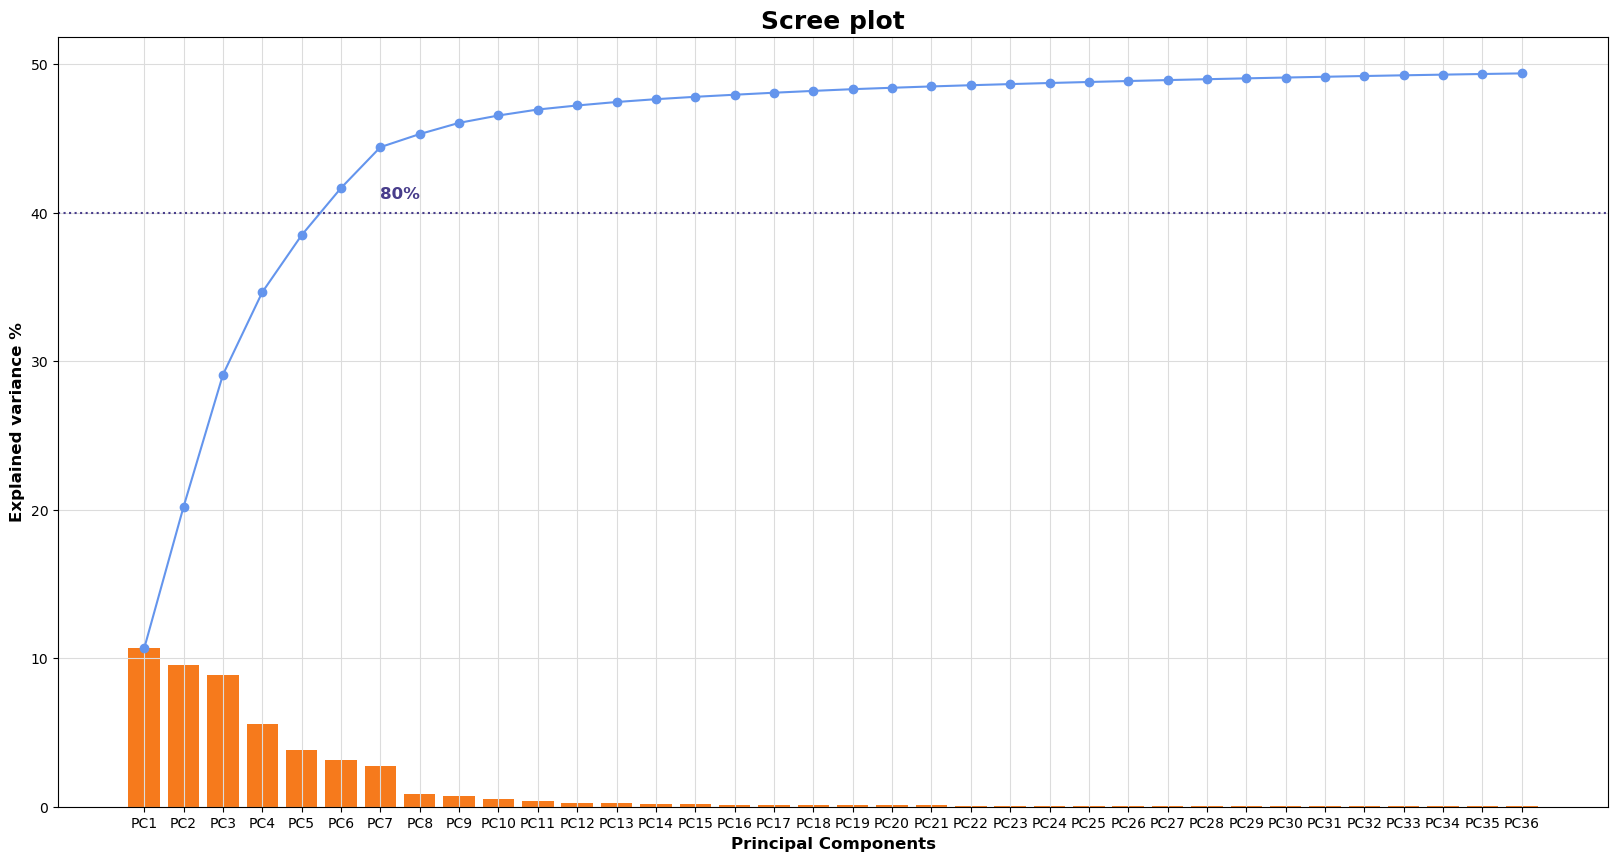

In [55]:
# scree plot - % explained variance
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=[20, 10])
plt.bar(df_var_trim['component'], df_var_trim['explained_var'], color=loopy)
plt.plot(df_var_trim['component'], df_var_trim['cum_var'], color='cornflowerblue', marker='o')
plt.xlabel("Principal Components", fontweight='bold', fontsize=12)
plt.xticks(np.arange(0, df_var_trim.shape[0], 1))
ax.set_yticklabels([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.ylabel("Explained variance %", fontweight='bold', fontsize=12)
plt.text(6, 0.82, "80%", color='darkslateblue', fontweight='bold', fontsize=12)
plt.axhline(y=0.8, color='darkslateblue', linestyle=':')
plt.title("Scree plot", fontweight='bold',fontsize=18)
plt.grid(axis='both', color='gainsboro')
plt.savefig("scree_trim.png", bbox_inches='tight')
plt.show(block=False)

In [56]:
# scree plot - % explained variance
# fig, ax = plt.subplots(1, 1, figsize=[20, 5])
# plt.bar(df_var['component'], df_var['explained_var'], color=loopy)
# plt.plot(df_var['component'], df_var['cum_var'], color='cornflowerblue', marker='o')
# plt.xlabel("Principal Components", fontweight='bold', fontsize=12)
# plt.ylabel("Explained variance %", fontweight='bold', fontsize=12)
# plt.text(6, 0.82, "80%", color='darkslateblue', fontweight='bold', fontsize=12)
# plt.axhline(y=0.8, color='darkslateblue', linestyle=':')
# plt.title("Scree plot", fontweight='bold',fontsize=18)
# plt.grid(axis='both', color='gainsboro')
# plt.savefig("scree_tot.png", bbox_inches='tight')
# plt.show(block=False)

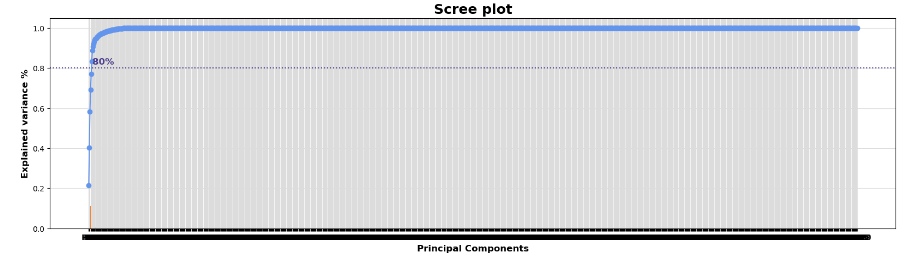

In [57]:
# convert pandas df to Spark df
spark_PCA = sqlContext.createDataFrame(df_var_trim)

In [58]:
# export PCA results to parquet file
spark_PCA.write.option("encoding", "utf-8").mode("overwrite").parquet(PATH_PCA)

In [59]:
# check export
df_PCA = pd.read_parquet(PATH_PCA, engine='pyarrow')
df_PCA.head()

,component,explained_var,cum_var
0,PC1,0.213449,0.213449
1,PC2,0.190681,0.404129
2,PC3,0.177832,0.581961
3,PC4,0.111142,0.693103
4,PC5,0.076807,0.769910


In [60]:
# export PCA results to csv file
df_var_trim.to_csv("PCA_results.csv", header=True, index=False, encoding='utf-8')